In [ ]:
# imports

import numpy as np
import pandas as pd
import time
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import ticker
import zlib
import os
import scipy.signal as sig

In [ ]:
# select record folder

folder = 'Data/T7/sbp/RISE_02'

# select device alias

alias = 'RISE_02'

# save folder

save_folder = './Cutter'

# filter options

reverse_xy = False
    
linear_baseline_correction = True

filter = True

low_freq = 0.1

high_freq = 20

filter_order = 4

# trigger options

STA = 3.0

LTA = 30.0

at = 3.0

adt = 1.0

atRMS = 0.2

PEM = 10

PET = 20

In [3]:
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

# record arrays

rec_t = np.empty(0)
rec_a = np.empty((0,3))

# packet info arrays

pck_packetbytes = np.empty(0).astype(int)
pck_packetsize = np.empty(0).astype(int)
pck_start = np.empty(0)
pck_dur = np.empty(0)
pck_gap = np.empty(0)
pck_gap = np.append(pck_gap,0)
pck_crc32 = np.empty(0).astype(int)
pck_crc32_calc = np.empty(0).astype(int)
pck_lat = np.empty(0).astype(float)
pck_lng = np.empty(0).astype(float)
pck_alt = np.empty(0).astype(int)
pck_vel = np.empty(0).astype(int)
pck_sats = np.empty(0).astype(int)
pck_rssi = np.empty(0).astype(int)
pck_ID = np.empty(0).astype(str)
pck_num = np.empty(0).astype(int)

# read binary file

TICKS_1000MS = 60000

with open(folder+'/packets/'+folder+'_'+alias+'.bin','rb') as binary_file:

    print(f"Postprocessing file : {folder+'/packets/'+folder+'_'+alias+'.bin'}")

    # first byte is packetsize
    
    packetsize = int.from_bytes(binary_file.read(1), byteorder='big')
        
    while True:
    
        packet = binary_file.read(10 + 9 * packetsize + 13 + 4 + 8)
            
        if not packet:
            break
            
        start = datetime.fromtimestamp( int.from_bytes(packet[0:4], 'big') ) + timedelta( seconds = int.from_bytes(packet[4:6], 'big') / TICKS_1000MS )
    
        dur = timedelta( seconds = int.from_bytes(packet[6:10], 'big') / TICKS_1000MS )
                  
        lat = int.from_bytes(packet[-25:-21], 'big')
        lng = int.from_bytes(packet[-21:-17], 'big')
        alt = int.from_bytes(packet[-17:-15], 'big')
        vel = int(packet[-15])
        sats = int(packet[-14])
        rssi = int(packet[-13])
            
        # received checksum
            
        crc32 = int.from_bytes(packet[-12:-8], 'big')
            
        # calculated checksum
            
        crc32_calc = zlib.crc32(packet[:-12]) & 0xffffffff
            
        # ID
          
        ID = packet[-8:-2].decode('utf-8',errors='ignore')
            
        # packet number
            
        num = int.from_bytes(packet[-2:], 'big')
          
        step = dur / packetsize
            
        t = np.array([start + i * step for i in range(0,packetsize)]) 
            
        # acceleration values
            
        a = np.zeros((packetsize,3))
  
        for col in range(0,3):
                
            line = 0
                
            for j in range(10+3*col, len(packet)-4, 9):
    
                val = (packet[j] << 12) | (packet[j+1] << 4) | (packet[j+2] >> 4)
    
                if val >= 524288:
                        
                    val = val - 1048576
                    
                try:
                        
                    a[line][col] = val / 256000
                    
                    line = line+1 
                        
                except:
                        
                    pass
                        
        # append to time and acceleration arrays - ignore corrupted packets

        if crc32 == crc32_calc:
            
            rec_t = np.append(rec_t,t)
            rec_a = np.vstack((rec_a,1000*a))
            
        # append to stats arrays
            
        pck_start = np.append(pck_start,start)
        pck_packetbytes = np.append(pck_packetbytes,(len(packet)))
        pck_packetsize = np.append(pck_packetsize,packetsize)
        pck_dur = np.append(pck_dur,dur)
            
        gap = (rec_t[len(rec_t)-packetsize] - rec_t[len(rec_t)-packetsize-1]).total_seconds()
            
        if len(rec_t) > packetsize:
            pck_gap = np.append(pck_gap, gap)
                
        pck_lat = np.append(pck_lat, lat/1e6)           
        pck_lng = np.append(pck_lng, lng/1e6)
        pck_alt = np.append(pck_alt, alt)           
        pck_vel = np.append(pck_vel, vel) 
        pck_sats = np.append(pck_sats, sats)
        pck_rssi = np.append(pck_rssi, -rssi)
            
        pck_crc32 = np.append(pck_crc32, crc32)
        pck_crc32_calc = np.append(pck_crc32_calc, crc32_calc)
            
        pck_ID = np.append(pck_ID, ID) 
        pck_num = np.append(pck_num, num)

# save record

rec_date = np.array([t.strftime('%d/%m/%Y') for t in rec_t])
rec_time = np.array([t.strftime('%H:%M:%S.%f') for t in rec_t])

df_rec = pd.DataFrame(rec_date, columns = ['Date'])
df_rec['Time'] = rec_time

df_rec['Seconds'] = np.array([(t - rec_t[0]).total_seconds() for t in rec_t])
    
df_rec['Acc x'] = rec_a[:,0]
df_rec['Acc y'] = rec_a[:,1]
df_rec['Acc z'] = rec_a[:,2]

df_rec['Seconds'] = df_rec['Seconds'].apply(lambda x: '{:.6f}'.format(x))

df_rec['Acc x'] = df_rec['Acc x'].apply(lambda x: '{:10.6f}'.format(x))
df_rec['Acc y'] = df_rec['Acc y'].apply(lambda x: '{:10.6f}'.format(x))
df_rec['Acc z'] = df_rec['Acc z'].apply(lambda x: '{:10.6f}'.format(x))
    
df_rec.to_csv(save_folder+'/'+folder+'_'+alias+'_rec.txt', sep = '\t', index = False)

print(f"Record saved : {save_folder+'/'+folder+'_'+alias+'_rec.txt'}")

# save packet info
    
pck_start_date = np.array([t.strftime('%d/%m/%Y') for t in pck_start])
pck_start_time = np.array([t.strftime('%H:%M:%S.%f') for t in pck_start])
pck_dur_secs = np.array([t.total_seconds() for t in pck_dur])
    
# number
df_pck = pd.DataFrame(pck_num, columns = ['#'])
# ID
df_pck['ID'] = pck_ID
# Packet size
df_pck['Size'] = pck_packetsize
# Packet length
df_pck['Bytes'] = pck_packetbytes
# Packet date
df_pck['Date'] = pck_start_date
# Packet time
df_pck['Time'] = pck_start_time
# Packet duration (as received)
df_pck['Dur read'] = 1000*pck_dur_secs
# Packet calculated duration (current packet time - previous packet time)
df_pck['Dur calc'] = np.concatenate((np.array([0]), 1000 * np.array([td.total_seconds() for td in np.diff(pck_start)])))
# Calculated samples per second from packet duration and packet size
df_pck['SPS'] = pck_packetsize/pck_dur_secs
# Calculated sample duration from packet duration and packet size
df_pck['dt'] = 1000*pck_dur_secs/pck_packetsize
# Time gap between current and previous packet
df_pck['Gap'] = 1000*pck_gap
# lat
df_pck['Lat'] = pck_lat
# lng
df_pck['Lng'] = pck_lng
# altitude
df_pck['Alt'] = pck_alt
# velocity
df_pck['Vel'] = pck_vel
# sats
df_pck['Sats'] = pck_sats
# rssi
df_pck['RSSI (dBm)'] = pck_rssi
# Packet CRC32
df_pck['CRC32 recv'] = pck_crc32
# Packet CRC32 calculated
df_pck['CRC32 calc'] = pck_crc32_calc
# check
df_pck['Check'] = np.where(df_pck['CRC32 recv'] == df_pck['CRC32 calc'], 'Ok', 'Corrupt')

df_pck['Dur read'] = df_pck['Dur read'].apply(lambda x: '{:.2f}'.format(x))
df_pck['Dur calc'] = df_pck['Dur calc'].apply(lambda x: '{:.2f}'.format(x))
df_pck['SPS'] = df_pck['SPS'].apply(lambda x: '{:.2f}'.format(x))
df_pck['dt'] = df_pck['dt'].apply(lambda x: '{:.2f}'.format(x))
df_pck['Gap'] = df_pck['Gap'].apply(lambda x: '{:.2f}'.format(x))
df_pck['Lat'] = df_pck['Lat'].apply(lambda x: '{:.6f}'.format(x))
df_pck['Lng'] = df_pck['Lng'].apply(lambda x: '{:.6f}'.format(x))
df_pck['CRC32 recv'] = df_pck['CRC32 recv'].apply(lambda x: '{:08X}'.format(x))
df_pck['CRC32 calc'] = df_pck['CRC32 calc'].apply(lambda x: '{:08X}'.format(x))

df_pck.to_csv(save_folder+'/'+folder+'_'+alias+'_pck.txt', sep = '\t', index = False)

print(f"Packets saved : {save_folder+'/'+folder+'_'+alias+'_pck.txt'}")

Postprocessing file : 2024_10_30_1351/packets/2024_10_30_1351_RISE_02.bin
Record saved : ./Cutter/2024_10_30_1351_RISE_02_rec.txt
Packets saved : ./Cutter/2024_10_30_1351_RISE_02_pck.txt


In [4]:
# time in seconds (starting from zero)

rec_t_sec = np.array([(t - rec_t[0]).total_seconds() for t in rec_t])

sps = len(rec_t_sec) / (rec_t_sec[-1] - rec_t_sec[0])

# reverse axes

if reverse_xy:
    rec_a[:, 0] = -rec_a[:, 0]
    rec_a[:, 1] = -rec_a[:, 1] 

# remove mean (zero-order correction)

rec_a_cor = rec_a - np.mean(rec_a, axis=0)

# linear baseline correction

if linear_baseline_correction:
    
    rec_a_cor = np.empty_like(rec_a)
    
    for i in range(3):
        
        signal = rec_a[:, i]
        mean_signal = np.mean(signal)
        mean_time = np.mean(rec_t_sec)

        numerator = np.sum((rec_t_sec - mean_time) * (signal - mean_signal))
        denominator = np.sum((rec_t_sec - mean_time) ** 2)
        slope = numerator / denominator
        intercept = mean_signal - slope * mean_time
        baseline = slope * rec_t_sec + intercept

        rec_a_cor[:, i] = signal - baseline
        
# bandpass filter

if filter:

    b, a = sig.butter(filter_order, [low_freq, high_freq], btype='band', fs = sps)

    rec_a_filt = np.apply_along_axis(lambda axis: sig.filtfilt(b, a, axis), axis=0, arr=rec_a_cor)

In [5]:
# print statistics

rms_x = np.sqrt(np.mean(rec_a_cor[:,0]**2))
rms_y = np.sqrt(np.mean(rec_a_cor[:,1]**2))
rms_z = np.sqrt(np.mean(rec_a_cor[:,2]**2))

pp_x = np.max(rec_a_cor[:,0]) - np.min(rec_a_cor[:,0])
pp_y = np.max(rec_a_cor[:,1]) - np.min(rec_a_cor[:,1])
pp_z = np.max(rec_a_cor[:,2]) - np.min(rec_a_cor[:,2])

max_x = np.max(rec_a_cor[:,0])
min_x = np.min(rec_a_cor[:,0])
max_y = np.max(rec_a_cor[:,1])
min_y = np.min(rec_a_cor[:,1])
max_z = np.max(rec_a_cor[:,2])
min_z = np.min(rec_a_cor[:,2])

print(f'Device : {alias}')
print()
print(f'RMS x  : {rms_x:10.3f}')
print(f'RMS y  : {rms_y:10.3f}')
print(f'RMS z  : {rms_z:10.3f}')
print(f'p-p x  : {pp_x:10.3f}')
print(f'p-p y  : {pp_y:10.3f}')
print(f'p-p z  : {pp_z:10.3f}')
print(f'Max x  : {max_x:10.3f}')
print(f'Min x  : {min_x:10.3f}')
print(f'Max y  : {max_y:10.3f}')
print(f'Min y  : {min_y:10.3f}')
print(f'Max z  : {max_z:10.3f}')
print(f'Min z  : {min_z:10.3f}')

if filter:
    
    print()
    
    rms_x = np.sqrt(np.mean(rec_a_filt[:,0]**2))
    rms_y = np.sqrt(np.mean(rec_a_filt[:,1]**2))
    rms_z = np.sqrt(np.mean(rec_a_filt[:,2]**2))
    
    pp_x = np.max(rec_a_filt[:,0]) - np.min(rec_a_filt[:,0])
    pp_y = np.max(rec_a_filt[:,1]) - np.min(rec_a_filt[:,1])
    pp_z = np.max(rec_a_filt[:,2]) - np.min(rec_a_filt[:,2])
    
    max_x = np.max(rec_a_filt[:,0])
    min_x = np.min(rec_a_filt[:,0])
    max_y = np.max(rec_a_filt[:,1])
    min_y = np.min(rec_a_filt[:,1])
    max_z = np.max(rec_a_filt[:,2])
    min_z = np.min(rec_a_filt[:,2])
    
    print(f'Device : {alias} - Filtered')
    print()
    print(f'RMS x  : {rms_x:10.3f}')
    print(f'RMS y  : {rms_y:10.3f}')
    print(f'RMS z  : {rms_z:10.3f}')
    print(f'p-p x  : {pp_x:10.3f}')
    print(f'p-p y  : {pp_y:10.3f}')
    print(f'p-p z  : {pp_z:10.3f}')
    print(f'Max x  : {max_x:10.3f}')
    print(f'Min x  : {min_x:10.3f}')
    print(f'Max y  : {max_y:10.3f}')
    print(f'Min y  : {min_y:10.3f}')
    print(f'Max z  : {max_z:10.3f}')
    print(f'Min z  : {min_z:10.3f}')

Device : RISE_02

RMS x  :      0.276
RMS y  :      0.240
RMS z  :      0.520
p-p x  :     17.176
p-p y  :     10.244
p-p z  :     42.824
Max x  :      8.333
Min x  :     -8.842
Max y  :      6.021
Min y  :     -4.222
Max z  :     18.159
Min z  :    -24.665

Device : RISE_02 - Filtered

RMS x  :      0.136
RMS y  :      0.188
RMS z  :      0.287
p-p x  :      5.146
p-p y  :      7.506
p-p z  :     13.454
Max x  :      2.511
Min x  :     -2.635
Max y  :      3.962
Min y  :     -3.543
Max z  :      6.816
Min z  :     -6.638


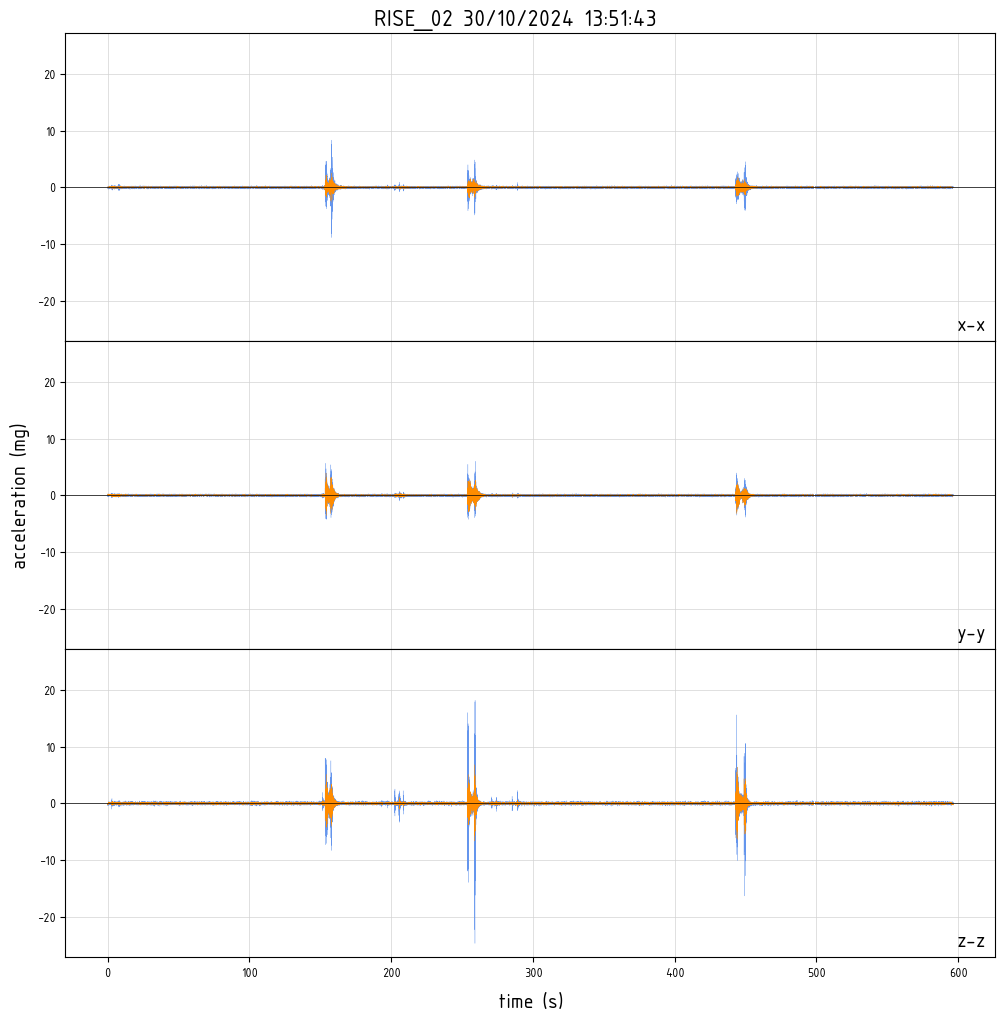

In [6]:
rcParams['font.family'] = 'isocpeur'

axisLabels = ['x-x', 'y-y', 'z-z']

fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

fig.suptitle(f"{alias} {pck_start[0].strftime('%d/%m/%Y %H:%M:%S')}", fontsize=18, y=0.9)

amax = 1.1 * max([np.max(np.abs(acc)) for acc in rec_a_cor])
    
for i, axis in enumerate(axisLabels):

    ax = axs[i]
    ax.grid(color='lightgray', linewidth=0.5)
    ax.set_title(f'{axis}', fontsize=16, x = 0.99, y=0.01, ha='right')
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    #ax.xaxis.set_major_locator(MaxNLocator(integer=True, min_n_ticks=5))
    ax.tick_params(axis='x', labelsize=10, rotation=0)
    ax.tick_params(axis='y', labelsize=10)
    ax.set_ylim(-amax, amax)

    ax.plot(rec_t_sec, rec_a_cor[:,i], linewidth=0.2, color='cornflowerblue', alpha=1.0)

    if filter:
        ax.plot(rec_t_sec, rec_a_filt[:,i], linewidth=0.2, color='darkorange', alpha=1.0)

    ax.axhline(0, color='black', linewidth=0.5)

    if i < 2:
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

axs[1].set_ylabel('acceleration (mg)', fontsize=16, labelpad=5)
axs[2].set_xlabel('time (s)', fontsize=16, labelpad=10)
plt.subplots_adjust(hspace=0)

plt.savefig(save_folder+'/'+folder+'_'+alias+'.png', bbox_inches = 'tight', dpi = 300, transparent = True)
plt.show()
plt.close()

In [7]:
# copy record to new arrays

t = np.copy(rec_t_sec)

if filter:
    a = np.copy(rec_a_filt)
else :
    a = np.copy(rec_a_cor)

# number of samples

nSTA = np.ceil(STA*sps).astype(int)
nLTA = np.ceil(LTA*sps).astype(int)
nPEM = np.ceil(PEM*sps).astype(int)
nPET = np.ceil(PET*sps).astype(int)

# acceleration vector

vec2 = np.sum(a**2, axis=1)
vec = np.sqrt(vec2)

# standard STA

sSTA = np.zeros_like(vec2)

sSTA[0] = vec2[0]

for i in range(1, len(vec2)):
    
    if i < nSTA:
        sSTA[i] = sSTA[i - 1] + (vec2[i] - sSTA[i - 1]) / (i + 1)
    else:
        sSTA[i] = sSTA[i - 1] + (vec2[i] - vec2[i - nSTA]) / nSTA

# standard LTA

sLTA = np.zeros_like(vec2)

sLTA[0] = vec2[0]

for i in range(1, len(vec2)):
    
    if i < nLTA:
        sLTA[i] = sLTA[i - 1] + (vec2[i] - sLTA[i - 1]) / (i + 1)
    else:
        sLTA[i] = sLTA[i - 1] + (vec2[i] - vec2[i - nLTA]) / nLTA

# recursive STA

rSTA = np.zeros_like(vec2)

rSTA[0] = vec2[0]

for i in range(1, len(vec2)):
    
    if i < nSTA:
        rSTA[i] = rSTA[i - 1] + (vec2[i] - sSTA[i - 1]) / (i + 1)
    else:
        rSTA[i] = rSTA[i - 1] + (vec2[i] - rSTA[i - 1]) / nSTA

# recursive LTA

rLTA = np.zeros_like(vec2)

rLTA[0] = vec2[0]

for i in range(1, len(vec2)):
    
    if i < nLTA:
        rLTA[i] = rLTA[i - 1] + (vec2[i] - rLTA[i - 1]) / (i + 1)
    else:
        rLTA[i] = rLTA[i - 1] + (vec2[i] - rLTA[i - 1]) / nLTA

# recursive STRMS

sSTA_RMS = np.zeros_like(vec)

sSTA_RMS[0] = vec[0]  # not squared

for i in range(1, len(vec)):
    
    if i < nSTA:
        sSTA_RMS[i] = sSTA_RMS[i - 1] + (vec[i] - sSTA_RMS[i - 1]) / (i + 1)
    else:
        sSTA_RMS[i] = sSTA_RMS[i - 1] + (vec[i] - vec[i - nSTA]) / nSTA

rSTRMS = np.zeros_like(vec)

rSTRMS[0] = 0

for i in range(1, len(vec)):
    
    if i < nSTA:
        rSTRMS[i] = (i/(i+1))*rSTRMS[i-1] + (1/i)*(vec[i]-sSTA_RMS[i])**2
    else:
        rSTRMS[i] = ((nSTA-1)/nSTA)*rSTRMS[i-1] + (1/(nSTA-1))*(vec[i]-sSTA_RMS[i])**2

rSTRMS = np.sqrt(rSTRMS)

# recursive simplified STRMS

rSTA_RMS = np.zeros_like(vec)

rSTA_RMS[0] = vec[0]  # not squared

for i in range(1, len(vec)):
    
    if i < nSTA:
        rSTA_RMS[i] = rSTA_RMS[i - 1] + (vec[i] - sSTA_RMS[i - 1]) / (i + 1)
    else:
        rSTA_RMS[i] = rSTA_RMS[i - 1] + (vec[i] - rSTA_RMS[i - 1]) / nSTA

rsSTRMS = np.zeros_like(vec)

rsSTRMS[0] = 0

for i in range(1, len(vec)):
    
    if i < nSTA:
        rsSTRMS[i] = rsSTRMS[i-1] + ((vec[i]-rSTA_RMS[i])**2 - rsSTRMS[i-1]) / (i+1)
    else:
        rsSTRMS[i] = rsSTRMS[i-1] + ((vec[i]-rSTA_RMS[i])**2 - rsSTRMS[i-1]) / nSTA

rsSTRMS = np.sqrt(rsSTRMS)

In [8]:
steps = []

above = False

for i in range(len(sSTA)):
    
    ratio = sSTA[i]/sLTA[i]
    
    time_step = t[i]

    if not above and ratio > at:

        steps.append(i)
        above = True
        
    elif above and ratio < adt:

        steps.append(i)
        above = False

if above: 
    steps.append(len(sSTA)-1)

steps_RMS = []

above = False

for i in range(len(rSTRMS)):
    
    time_step = t[i]

    if not above and rSTRMS[i] > atRMS:

        steps_RMS.append(i)
        above = True
        
    elif above and rSTRMS[i] < atRMS:

        steps_RMS.append(i)
        above = False

if above: 
    steps.append(len(rSTRMS)-1)

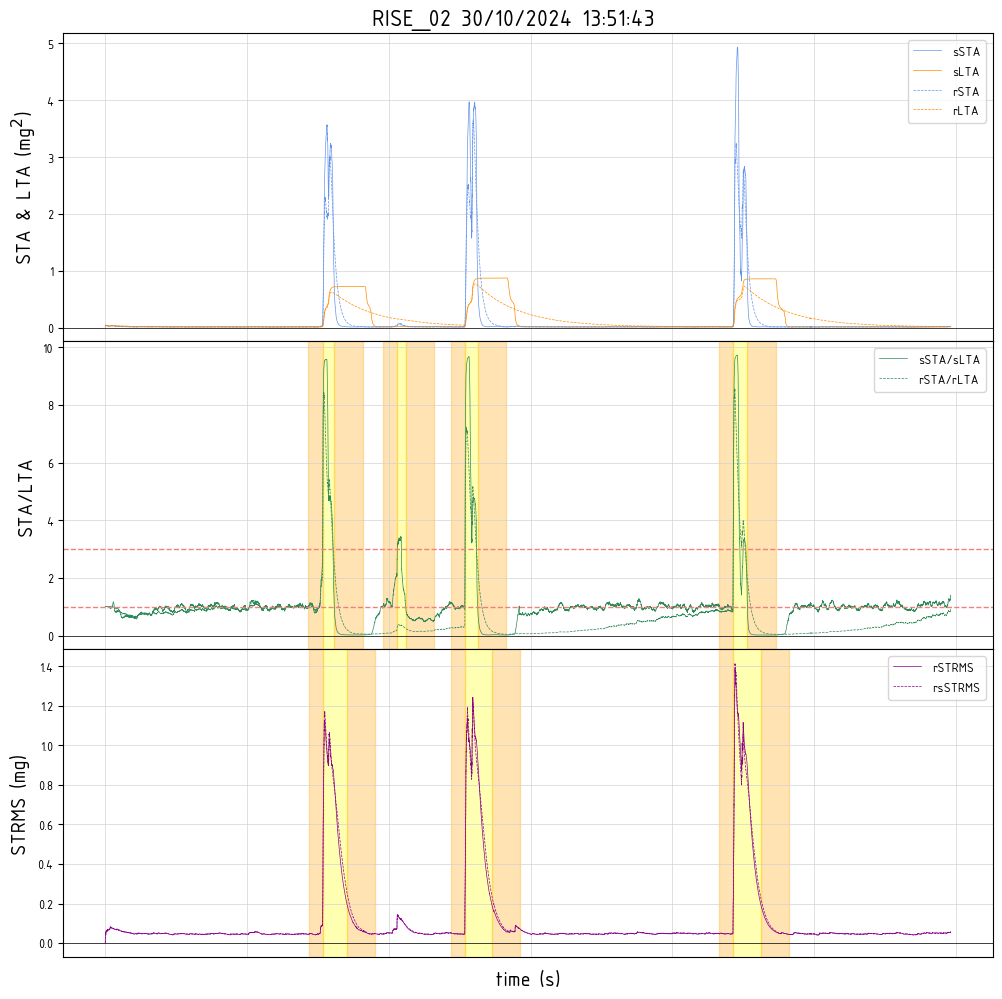

In [9]:
rcParams['font.family'] = 'isocpeur'

fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

fig.suptitle(f"{alias} {pck_start[0].strftime('%d/%m/%Y %H:%M:%S')}", fontsize=18, y=0.9)

# STA & LTA

axs[0].grid(color='lightgray', linewidth=0.5)
axs[0].tick_params(axis='x', labelsize=10, rotation=0)
axs[0].tick_params(axis='y', labelsize=10)

axs[0].plot(rec_t_sec, sSTA, linewidth=0.5, label='sSTA', color='cornflowerblue', alpha=1.0)
axs[0].plot(rec_t_sec, sLTA, linewidth=0.5, label='sLTA', color='darkorange', alpha=1.0)
axs[0].plot(rec_t_sec, rSTA, linewidth=0.5, label='rSTA', color='cornflowerblue', alpha=1.0, linestyle='dashed')
axs[0].plot(rec_t_sec, rLTA, linewidth=0.5, label='rLTA', color='darkorange', alpha=1.0, linestyle='dashed')

axs[0].axhline(0, color='black', linewidth=0.5)
axs[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
axs[0].legend(loc='upper right', fontsize=10)
axs[0].set_ylabel('STA & LTA (mg$^2$)', fontsize=16, labelpad=5)

# STA/LTA ratio

axs[1].grid(color='lightgray', linewidth=0.5)
axs[1].tick_params(axis='x', labelsize=10, rotation=0)
axs[1].tick_params(axis='y', labelsize=10)

axs[1].plot(rec_t_sec, sSTA/sLTA, linewidth=0.5, label='sSTA/sLTA', color='seagreen', alpha=1.0)
axs[1].plot(rec_t_sec, rSTA/rLTA, linewidth=0.5, label='rSTA/rLTA', color='seagreen', alpha=1.0, linestyle='dashed')

axs[1].axhline(at, color='lightcoral', linewidth=1, linestyle='dashed')
axs[1].axhline(adt, color='lightcoral', linewidth=1, linestyle='dashed')
axs[1].axhline(0, color='black', linewidth=0.5)
axs[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
axs[1].legend(loc='upper right', fontsize=10)
axs[1].set_ylabel('STA/LTA', fontsize=16, labelpad=5)

for i in range(0, len(steps) - 1, 2):
    axs[1].axvspan(t[steps[i]], t[steps[i + 1]], color='yellow', alpha=0.3)
    axs[1].axvspan(t[steps[i]-nPEM], t[steps[i]], color='orange', alpha=0.3)
    axs[1].axvspan(t[steps[i+1]], t[steps[i+1]+nPET], color='orange', alpha=0.3)

# STRMS

axs[2].grid(color='lightgray', linewidth=0.5)
axs[2].tick_params(axis='x', labelsize=10, rotation=0)
axs[2].tick_params(axis='y', labelsize=10)

axs[2].plot(rec_t_sec, rSTRMS, linewidth=0.5, label='rSTRMS', color='darkmagenta', alpha=1.0)
axs[2].plot(rec_t_sec, rsSTRMS, linewidth=0.5, label='rsSTRMS', color='darkmagenta', alpha=1.0, linestyle='dashed')

axs[2].axhline(0, color='black', linewidth=0.5)
axs[2].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
axs[2].legend(loc='upper right', fontsize=10)
axs[2].set_ylabel('STRMS (mg)', fontsize=16, labelpad=5)

for i in range(0, len(steps_RMS) - 1, 2):
    axs[2].axvspan(t[steps_RMS[i]], t[steps_RMS[i + 1]], color='yellow', alpha=0.3)
    axs[2].axvspan(t[steps_RMS[i]-nPEM], t[steps_RMS[i]], color='orange', alpha=0.3)
    axs[2].axvspan(t[steps_RMS[i+1]], t[steps_RMS[i+1]+nPET], color='orange', alpha=0.3)
    
axs[2].set_xlabel('time (s)', fontsize=16, labelpad=10)

plt.subplots_adjust(hspace=0)

plt.savefig(save_folder+'/'+folder+'_'+alias+'_triggers.png', bbox_inches = 'tight', dpi = 300, transparent = True)
plt.show()
plt.close()

In [10]:
# cut records

for i in range(0, len(steps), 2):
    
    start_index = steps[i]-nPEM
    end_index = steps[i + 1]+nPET

    sub_df_rec = df_rec.iloc[start_index:end_index + 1].copy()

    sub_df_rec['Seconds (orig)'] = pd.to_numeric(sub_df_rec['Seconds'], errors='coerce')
    sub_df_rec['Seconds'] = sub_df_rec['Seconds (orig)'] - sub_df_rec['Seconds (orig)'].iloc[0]
    sub_df_rec['Seconds'] = sub_df_rec['Seconds'].apply(lambda x: '{:.6f}'.format(x))
    
    sub_df_rec = sub_df_rec[['Date', 'Time', 'Seconds', 'Acc x', 'Acc y', 'Acc z']]
    
    sub_record_name = f"{save_folder}/{folder}_{alias}_sub_rec_{i//2 + 1}.txt"
    
    sub_df_rec.to_csv(sub_record_name, sep='\t', index=False)

    print(f"Sub-record saved : {sub_record_name}")

Sub-record saved : ./Cutter/2024_10_30_1351_RISE_02_sub_rec_1.txt
Sub-record saved : ./Cutter/2024_10_30_1351_RISE_02_sub_rec_2.txt
Sub-record saved : ./Cutter/2024_10_30_1351_RISE_02_sub_rec_3.txt
Sub-record saved : ./Cutter/2024_10_30_1351_RISE_02_sub_rec_4.txt
